# Projeto "Ruptura Zero": Análise de Vendas e Estoque

> O projeto 'Ruptura Zero' visa otimizar a gestão de inventário para minimizar perdas de vendas decorrentes da falta de produtos em estoque.

Este notebook tem como objetivo validar o sucesso do processo ETL realizado para o projeto Ruptura Zero. Aqui, são executadas consultas diretamente no banco de dados MotherDuck para verificar se os dados foram corretamente extraídos, transformados e carregados. Por meio das análises apresentadas, é possível confirmar que as informações estão disponíveis e estruturadas conforme esperado, garantindo a integridade e a qualidade dos dados submetidos ao ambiente analítico.

In [1]:
import os

import duckdb as db
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

In [2]:
# Carregar variáveis de ambiente
load_dotenv()
motherduck_token = os.getenv('MOTHERDUCK_TOKEN')

if not motherduck_token:
    print('O token do MotherDuck (MOTHERDUCK_TOKEN) não foi encontrado no ambiente.')
    print('Por favor, crie um arquivo .env ou defina a variável de ambiente.')
    print('Você pode obter um token em: https://app.motherduck.com/')

In [3]:
def fetch_motherduck_data(query: str, read_only: bool = True, verbose: bool = False) -> pd.DataFrame:
    """Obtém dados do banco de dados MotherDuck.

    Esta função executa uma consulta SQL no banco de dados MotherDuck e retorna os
    resultados como um DataFrame do pandas.

    Args:
        query (str): A consulta SQL a ser executada.
        read_only (bool): Indica se a conexão deve ser somente leitura. Padrão é True.
        verbose (bool): Se True, imprime informações detalhadas sobre a execução da consulta. Padrão é False.

    """
    try:
        with db.connect(database='md:', read_only=read_only) as connection:
            data_frame = connection.execute(query).fetch_df()

            if verbose:
                print(f"Consulta executada com sucesso. Linhas retornadas: {len(data_frame)}")

            return data_frame
    except db.Error as error:
        print("Erro ao conectar ou consultar o banco de dados:", error)

        return pd.DataFrame()

## **QUESTÃO 01**: Quais são os 5 clientes com maior valor total de ruptura no período analisado?

In [4]:
query_01 = """
    SELECT
        ruptura.nome_cliente AS "Cliente",
        ruptura.tipo_cliente AS "Tipo Cliente",
        ROUND(SUM(ruptura.valor_ruptura), 2) AS "Total Ruptura"
    FROM
        my_db.ruptura_zero_analysis AS ruptura
    GROUP BY ALL
    ORDER BY
        "Total Ruptura" DESC
    LIMIT 5
    """

top_clients_rupture = fetch_motherduck_data(query_01)

if top_clients_rupture.empty:
    print('Nenhum dado encontrado para os principais clientes.')
else:
    print('Principais clientes com maior valor de ruptura:')
    print(top_clients_rupture)

Principais clientes com maior valor de ruptura:
     Cliente Tipo Cliente  Total Ruptura
0       RUBI       PADRÃO      683486.90
1  ESMERALDA     ESPECIAL      649223.79
2   DIAMANTE     ESPECIAL      390915.84
3      PRATA       PADRÃO      356074.33
4       OURO       PADRÃO      312370.50


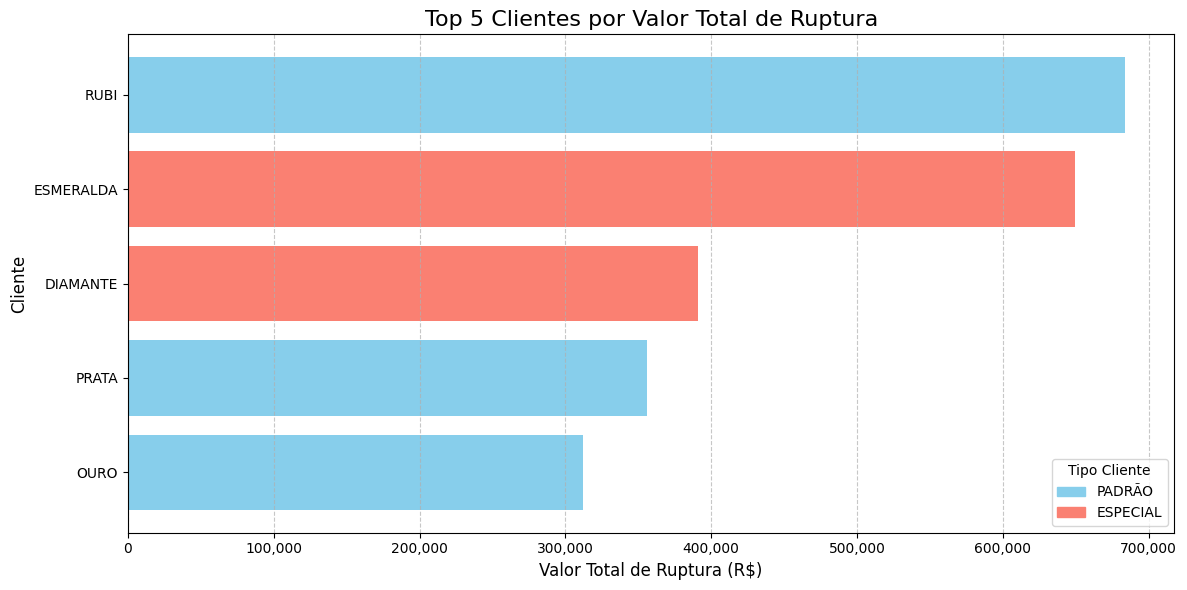

In [5]:
# Mapeia os tipos de cliente para cores diferentes
color_map = {'PADRÃO': 'skyblue', 'ESPECIAL': 'salmon'}
top_clients_rupture['colors'] = top_clients_rupture['Tipo Cliente'].map(color_map)

# Inverte a ordem do DataFrame para que o maior valor fique no topo do gráfico
df_sorted = top_clients_rupture.iloc[::-1]

fig, ax = plt.subplots(figsize=(12, 6))

# Cria o gráfico de barras horizontais
ax.barh(df_sorted['Cliente'],
        df_sorted['Total Ruptura'],
        color=df_sorted['colors'])

# Adiciona títulos e rótulos
ax.set_title('Top 5 Clientes por Valor Total de Ruptura', fontsize=16)
ax.set_xlabel('Valor Total de Ruptura (R$)', fontsize=12)
ax.set_ylabel('Cliente', fontsize=12)

# Formata o eixo X para melhor legibilidade (milhares)
ax.xaxis.set_major_formatter('{x:,.0f}')

# Cria a legenda manualmente
legend_handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in color_map]
ax.legend(legend_handles, color_map.keys(), title='Tipo Cliente')

# Remove a grade desnecessária e ajusta o layout
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

## **QUESTÃO 02**: No mês mais recente, quais são as três categorias de produto com a maior cobertura média de estoque?

In [6]:
query_02 = """
    SELECT
        MAX(ruptura.ano) AS "Ano",
        MAX(ruptura.mes) AS "Mes Atual",
        ruptura.categoria_material AS "Categoria Material",
        ROUND(AVG(ruptura.cobertura_dias), 4) AS "Média Cobertura"
    FROM
        my_db.ruptura_zero_analysis AS ruptura
    GROUP BY
        ruptura.categoria_material
    ORDER BY
        "Média Cobertura" DESC
    LIMIT 3
"""

highest_avg_coverage = fetch_motherduck_data(query_02)
if highest_avg_coverage.empty:
    print('Nenhum dado encontrado para as principais categorias de produtos com cobertura média.')
else:
    print('Principais categorias de produtos com cobertura média:')
    print(highest_avg_coverage)

Principais categorias de produtos com cobertura média:
    Ano  Mes Atual    Categoria Material  Média Cobertura
0  2021          7  CUIDADOS COM A BARBA         147.1026
1  2021          7             MAQUIAGEM         119.4872
2  2021          7             HOME CARE          93.9464


## **QUESTÃO 03**: Qual foi o mês com o maior volume total de vendas?


In [7]:
query_03 = """
    SELECT
        ano AS "Ano",
        strftime(make_date(ano, mes, 1), '%B') AS "Mês",
        SUM(valor_volume_real) AS "Valor Volume Real"
    FROM my_db.ruptura_zero_analysis
    GROUP BY ALL
    ORDER BY "Valor Volume Real" DESC
    LIMIT 1;
"""

highest_sales_month = fetch_motherduck_data(query_03)
if highest_sales_month.empty:
    print('Nenhum dado encontrado para o mês com o maior volume total de vendas.')
else:
    print('Mês com o maior volume total de vendas:')
    print(highest_sales_month)

Mês com o maior volume total de vendas:
    Ano      Mês  Valor Volume Real
0  2021  January          1381385.0
